In [1]:
import pandas as pd
import numpy as np
import os
import math
import statistics

In [2]:
df = pd.read_csv('final_csvs/all_risk_df_ordered.csv', index_col=0)

In [3]:
df = df.fillna(0)

In [4]:
df = df.rename({'ranking_y':'ranking'}, axis=1)

In [5]:
df.head()

,matchId,teamId,distance1_2_x,distance1_3_x,distance1_4_x,distance2_3_x,distance2_4_x,distance3_4_x,distance_centroid1_x,distance_centroid2_x,...,landing_risk3,landing_risk4,risk1,risk2,risk3,risk4,risk_std1,risk_std2,risk_std3,risk_std4
0,000fe633-8af8-4037-b318-a1ca39ded6df,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,1.500000,0.000000,0.000000,0.000000,2.121320
1,000fe633-8af8-4037-b318-a1ca39ded6df,2,0.166337,0.155716,0.511556,0.000000,0.000000,0.000000,0.535103,0.168181,...,49.0,0.0,4.100000,8.076923,2.650000,0.000000,6.463664,11.732511,2.661124,0.000000
2,000fe633-8af8-4037-b318-a1ca39ded6df,3,0.292997,0.277253,0.297357,0.255394,0.293448,0.430611,0.351448,0.333458,...,1.0,0.0,0.731707,1.694301,0.450777,0.201258,1.830544,4.923881,0.934808,0.582225
3,000fe633-8af8-4037-b318-a1ca39ded6df,4,0.245044,0.256591,0.321896,0.273480,0.247005,0.274637,0.292093,0.272388,...,0.0,0.0,0.553191,0.322581,0.414894,0.232558,1.528349,0.768416,0.781638,0.546097
4,000fe633-8af8-4037-b318-a1ca39ded6df,5,0.192947,0.174149,0.186268,0.183944,0.192415,0.239797,0.237815,0.208418,...,0.0,0.0,0.630058,0.444444,0.568047,0.408602,1.843158,0.871572,1.252301,0.875221


First, we look at how many teams have null values in the distance columns, meaning that the teams are of less than 4 people. We look for 99s because we previously made all the distance nans to have value 99. 

In [6]:
for c in df.columns:
    if ('distance' in c) and ('y' in c):
        nns = len([i for i in df[c] if i == 99])
        total = len(df[c])
        print(f'{c} has {(nns/total)*100}% null values')

distance1_2_y has 8.731105995131433% null values
distance1_3_y has 13.501075613760309% null values
distance1_4_y has 13.686241579076484% null values
distance2_3_y has 33.7516275734531% null values
distance2_4_y has 33.83135508463382% null values
distance3_4_y has 33.941982903402334% null values
distance_centroid1_y has 0.07595342781122034% null values
distance_centroid2_y has 8.286707678372615% null values
distance_centroid3_y has 12.95572056686732% null values
distance_centroid4_y has 32.82933595003114% null values


Then, we drop them. We decide to focus only on 4-player teams.

In [7]:
df = df.replace(99, np.nan)
df = df.dropna()
df = df.drop('n_players_y', axis=1)

For the risk variable, we derive a new interaction variable. This is risk * risk_std since we saw that they were highly correlated, so we try to capture the effect of the variance in risk with another variable.

In [8]:
col = df.loc[: , "risk_std1":"risk_std4"]
df['risk_std_mean'] = col.mean(axis=1)
col         = 'risk_std_mean'
conditions  = [ df[col] > statistics.median(df[col])+statistics.stdev(df[col]), (df[col]<statistics.median(df[col])+statistics.stdev(df[col])) & (df[col]>statistics.median(df[col])), df[col] <= statistics.median(df[col]) ]
# choices     = [ "Exploit", 'Ambidexter', 'Explore' ]
choices     = [ '1', '0', '-1' ]
df["risk_category"] = np.select(conditions, choices, default=np.nan)
df = df.drop('risk_std_mean', axis=1)
df.risk_category = df.risk_category.astype(int)

In [9]:
df['risk_int1'] = df['risk1'] * df['risk_std1']
df['risk_int2'] = df['risk2'] * df['risk_std2']
df['risk_int3'] = df['risk3'] * df['risk_std3']
df['risk_int4'] = df['risk4'] * df['risk_std4']
df = df.drop(['risk_std1','risk_std2','risk_std3','risk_std4'], axis=1)

Now, we order risk variables from highest to lowest, so that the new variables represent from the riskiest player to the least risky player.

In [10]:
risk = df.loc[:, 'risk1':'risk4']
risk = np.sort(risk.values, axis=1)[:,::-1]
df.loc[:, 'risk1':'risk4'] = risk
risk_std = df.loc[:, 'risk_int1':'risk_int4']
risk_std = np.sort(risk_std.values, axis=1)[:,::-1]
df.loc[:, 'risk_int1':'risk_int4'] = risk_std
lrisk = df.loc[:, 'landing_risk1':'landing_risk4']
lrisk = np.sort(lrisk.values, axis=1)[:,::-1]
df.loc[:, 'landing_risk1':'landing_risk4'] = lrisk

Since the sum of the Cluster columns is always 1, we have a very high correlation. For that reason, we drop one of them. In this case, we drop Cluster A because we see that it is the one with the highest correlation with the others.

In [11]:
df.loc[:,'cluster_A_x':'cluster_D_x'].corr()

,cluster_A_x,cluster_B_x,cluster_C_x,cluster_D_x
cluster_A_x,1.000000,0.736410,0.832994,0.702756
cluster_B_x,0.736410,1.000000,0.442025,0.227406
cluster_C_x,0.832994,0.442025,1.000000,0.705990
cluster_D_x,0.702756,0.227406,0.705990,1.000000


In [12]:
df.loc[:,'cluster_A_y':'cluster_D_y'].corr()

,cluster_A_y,cluster_B_y,cluster_C_y,cluster_D_y
cluster_A_y,1.000000,-0.924936,-0.900785,-0.733495
cluster_B_y,-0.924936,1.000000,0.692157,0.483973
cluster_C_y,-0.900785,0.692157,1.000000,0.749455
cluster_D_y,-0.733495,0.483973,0.749455,1.000000


In [13]:
df = df.drop(['cluster_A_x','cluster_A_y'], axis=1)

Now, we merge rankpoints

In [14]:
rkpts = pd.read_csv('experience_data/rankpoints_csv.csv', index_col=0)
df = pd.merge(df, rkpts, how='left', on=['matchId', 'teamId'])

Next, we create the control variables for all the groups of variable.
We will use as control the mean of each group for the match. E.g. for pair distances, we will control for the mean pair player distance of the match.

In [15]:
group = df.groupby(['matchId']).mean().reset_index()
mean_distance = pd.concat([group.matchId, group[['distance1_2_y', 'distance1_3_y', 'distance1_4_y', 'distance2_3_y', 'distance2_4_y', 'distance3_4_y']].apply(np.mean, axis=1)], axis=1)
mean_distance.columns = ['matchId','distance_ctrl']
# mean_centroid = pd.concat([group.matchId, group[['distance_centroid1_y', 'distance_centroid2_y', 'distance_centroid3_y', 'distance_centroid4_y']].apply(np.mean, axis=1)], axis=1)
# mean_centroid.columns = ['matchId','centroid_ctrl']
mean_cluster = pd.concat([group.matchId, group[['cluster_B_y', 'cluster_C_y','cluster_D_y']].apply(np.mean, axis=1)], axis=1)
mean_cluster.columns = ['matchId','cluster_ctrl']
mean_distance_std = pd.concat([group.matchId, group[['distance1_2_x', 'distance1_3_x', 'distance1_4_x', 'distance2_3_x', 'distance2_4_x', 'distance3_4_x']].apply(np.mean, axis=1)], axis=1)
mean_distance_std.columns = ['matchId','distance_std_ctrl']
mean_cluster_std = pd.concat([group.matchId, group[['cluster_B_x', 'cluster_C_x','cluster_D_x']].apply(np.mean, axis=1)], axis=1)
mean_cluster_std.columns = ['matchId','cluster_std_ctrl']
mean_exp = pd.concat([group.matchId, group[['exp1', 'exp2', 'exp3', 'exp4']].apply(np.mean, axis=1)], axis=1)
mean_exp.columns = ['matchId','exp_ctrl']
mean_risk = pd.concat([group.matchId, group[['risk1', 'risk2', 'risk3', 'risk4']].apply(np.mean, axis=1)], axis=1)
mean_risk.columns = ['matchId','risk_ctrl']
# mean_lrisk = pd.concat([group.matchId, group[['landing_risk1', 'landing_risk2', 'landing_risk3', 'landing_risk4']].apply(np.mean, axis=1)], axis=1)
# mean_lrisk.columns = ['matchId','landing_risk_ctrl']
mean_agi = group[['matchId', 'agility_y']]
mean_agi.columns = ['matchId','agi_ctrl']
df = pd.merge(df, mean_distance, how = 'left', on="matchId")
# df = pd.merge(df, mean_centroid, how = 'left', on="matchId")
df = pd.merge(df, mean_cluster, how = 'left', on="matchId")
df = pd.merge(df, mean_distance_std, how = 'left', on="matchId")
df = pd.merge(df, mean_cluster_std, how = 'left', on="matchId")
df = pd.merge(df, mean_exp, how = 'left', on="matchId")
df = pd.merge(df, mean_risk, how = 'left', on="matchId")
# df = pd.merge(df, mean_lrisk, how = 'left', on="matchId")
df = pd.merge(df, mean_agi, how = 'left', on="matchId")

Now, since experience was already a control variable, we are going to engineer the variable. For that, we are going to normalize the experiences of the palyers by the mean experience of the match, and then we are going to get the aggregate experience for the team. We sum 1 to the denominator in case there is some mean exp that is equal to 0.

In [16]:
df['exp1'] = df['exp1'] / (df['exp_ctrl'] + 1)
df['exp2'] = df['exp2'] / (df['exp_ctrl'] + 1)
df['exp3'] = df['exp3'] / (df['exp_ctrl'] + 1)
df['exp4'] = df['exp4'] / (df['exp_ctrl'] + 1)
df['exp'] = df['exp1'] + df['exp2'] + df['exp3'] + df['exp4']
df = df.drop(['exp1','exp2','exp3','exp4', 'exp_ctrl'], axis=1)

Since we have many players for whom we don't know the experience, we are going to drop them.<br><BR>

In [17]:
df = df.dropna()
# for match in df.matchId.unique():
#     df.loc[df.matchId == match,'new_ranking'] = df.loc[df.matchId == match,'ranking'].rank()

To make things easiear, we make sure that ranking is the last column.

In [18]:
ranking = df.pop('ranking')
df.insert(df.shape[1], 'ranking', ranking)

Since we have many variables ordered, we drop the middle variables to stay only with max and min variables (they don't add much to the model).

In [19]:
df = df.drop(['distance1_3_x', 'distance1_4_x', 'distance2_3_x', 'distance2_4_x',
              'distance1_3_y', 'distance1_4_y', 'distance2_3_y', 'distance2_4_y', 
              'distance_centroid2_x', 'distance_centroid3_x', 'distance_centroid2_y', 'distance_centroid3_y',
              'risk2', 'risk3', 'risk_int2', 'risk_int3', 'landing_risk2','landing_risk3'], axis=1)

Now, let's remove the outliers. For that, we use the Z-score, and we will remove all rows with z-score bigger than 3 (3 standard deviations away from the mean)

In [20]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df.iloc[:,2:-2]))
print(z)

[[0.92692223 0.30023189 0.18058086 ... 0.50597316 0.38732937 0.83124817]
 [0.21930519 0.36002175 0.06435607 ... 0.50597316 0.38732937 0.83124817]
 [0.67190685 0.12401626 0.00193791 ... 0.29091025 0.77306989 0.70359415]
 ...
 [0.52250665 0.29702793 0.25457316 ... 0.35769113 0.97588646 0.901968  ]
 [0.16564704 0.94093664 0.1639105  ... 0.35769113 0.97588646 0.901968  ]
 [1.03131327 0.50407273 0.35859487 ... 0.35769113 0.97588646 0.901968  ]]


In [21]:
pd.DataFrame(z, columns = df.iloc[:,2:-2].columns)

,distance1_2_x,distance3_4_x,distance_centroid1_x,distance_centroid4_x,cluster_B_x,cluster_C_x,cluster_D_x,distance1_2_y,distance3_4_y,distance_centroid1_y,...,risk4,risk_category,risk_int1,risk_int4,distance_ctrl,cluster_ctrl,distance_std_ctrl,cluster_std_ctrl,risk_ctrl,agi_ctrl
0,0.926922,0.300232,0.180581,0.369957,0.201728,0.251532,0.760627,0.383365,0.530634,0.132617,...,0.003791,1.486230,0.229260,0.163486,0.799435,0.419197,0.293564,0.505973,0.387329,0.831248
1,0.219305,0.360022,0.064356,0.269392,0.100320,0.376131,0.760627,0.636622,0.279775,0.112711,...,0.374726,0.227749,0.267919,0.262108,0.799435,0.419197,0.293564,0.505973,0.387329,0.831248
2,0.671907,0.124016,0.001938,0.058287,1.319526,1.270383,1.507291,0.632251,1.448451,0.891803,...,0.648427,1.030732,0.399919,0.303324,0.792169,0.556035,0.300759,0.290910,0.773070,0.703594
3,1.297694,0.789096,0.262176,0.029262,0.716686,0.893668,0.760627,0.148776,0.840956,0.430051,...,0.022374,0.227749,0.028330,0.243837,0.792169,0.556035,0.300759,0.290910,0.773070,0.703594
4,0.687520,0.090827,0.267869,0.232299,0.021592,1.076413,0.679565,0.674790,0.976507,1.046304,...,0.606091,1.030732,0.400386,0.302030,0.792169,0.556035,0.300759,0.290910,0.773070,0.703594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137144,0.449227,1.068160,0.062974,0.078657,0.779637,1.467615,0.760627,1.273019,0.653347,1.094452,...,0.504894,1.030732,0.389448,0.287901,1.520256,0.719222,0.867844,0.357691,0.975886,0.901968
137145,0.072269,0.232337,0.103075,0.258668,0.043290,0.114292,0.760627,0.709562,0.927061,0.677225,...,0.557283,1.030732,0.396343,0.297515,1.520256,0.719222,0.867844,0.357691,0.975886,0.901968
137146,0.522507,0.297028,0.254573,0.241310,0.705822,0.241478,0.198082,1.364197,0.370647,0.814945,...,0.111916,0.227749,0.346993,0.176472,1.520256,0.719222,0.867844,0.357691,0.975886,0.901968
137147,0.165647,0.940937,0.163911,0.139843,0.221253,0.031096,0.760627,0.836799,0.338807,0.413713,...,0.561482,1.030732,0.395324,0.299419,1.520256,0.719222,0.867844,0.357691,0.975886,0.901968


In [22]:
df = df[(z < 3).all(axis=1)]

In [23]:
df.shape

(114625, 32)

Then, we separate the two df that we are going to study

In [24]:
pd.set_option('display.max_columns', 48)
pd.DataFrame(df.columns).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,matchId,teamId,distance1_2_x,distance3_4_x,distance_centroid1_x,distance_centroid4_x,cluster_B_x,cluster_C_x,cluster_D_x,distance1_2_y,distance3_4_y,distance_centroid1_y,distance_centroid4_y,cluster_B_y,cluster_C_y,cluster_D_y,agility_y,landing_risk1,landing_risk4,risk1,risk4,risk_category,risk_int1,risk_int4,distance_ctrl,cluster_ctrl,distance_std_ctrl,cluster_std_ctrl,risk_ctrl,agi_ctrl,exp,ranking


In [25]:
# distances and centroids
df1 = pd.concat([df.iloc[:,0:6], df.iloc[:,9:13], df.iloc[:,16:25], df.iloc[:,26:27], df.iloc[:,28:]], axis=1)

# distances and clusters
df2 = pd.concat([df.iloc[:,0:4], df.iloc[:,6:11], df.iloc[:,13:]], axis=1)


Here, I just check the correlations. There is probably something that we can do about high correlations, though.

In [26]:
df2.iloc[:,2:].corr().style.apply(lambda x: ["background: red" if abs(v) > 0.75 else "" for v in x], axis = 1)

,distance1_2_x,distance3_4_x,cluster_B_x,cluster_C_x,cluster_D_x,distance1_2_y,distance3_4_y,cluster_B_y,cluster_C_y,cluster_D_y,agility_y,landing_risk1,landing_risk4,risk1,risk4,risk_category,risk_int1,risk_int4,distance_ctrl,cluster_ctrl,distance_std_ctrl,cluster_std_ctrl,risk_ctrl,agi_ctrl,exp,ranking
distance1_2_x,1,0.141215,0.107219,0.0899015,0.083418,-0.11716,0.00113322,0.0366778,0.0560951,0.0615009,-0.240066,-0.0604007,-0.0594699,-0.0602032,-0.0667037,-0.0678289,-0.0429879,-0.0316073,0.0263042,0.076097,0.255239,0.0926123,-0.0881066,-0.104497,0.0095732,-0.191595
distance3_4_x,0.141215,1,0.0287539,0.0909555,0.173686,0.118786,-0.168791,0.0320767,0.0976752,0.175484,0.0199345,-0.0442505,-0.0261888,-0.071749,-0.0396402,-0.0493926,-0.0485175,-0.0277311,-0.0318786,-0.13355,0.228662,-0.122347,0.0543271,0.0953928,0.042477,-0.1438
cluster_B_x,0.107219,0.0287539,1,0.425861,0.218903,0.305393,0.239676,0.65925,0.262474,0.150315,0.0607861,-0.201124,-0.280949,-0.229771,-0.356461,-0.246234,-0.165776,-0.283398,0.105348,0.292917,-0.0320323,0.32478,-0.215739,-0.0500134,-0.0678196,-0.0970697
cluster_C_x,0.0899015,0.0909555,0.425861,1,0.666797,0.444547,0.434992,0.67252,0.881033,0.569203,0.0310985,-0.323572,-0.371941,-0.332649,-0.449721,-0.388376,-0.243914,-0.342854,0.0992084,0.453741,-0.0230657,0.478267,-0.353917,-0.0884286,-0.0921627,-0.00264003
cluster_D_x,0.083418,0.173686,0.218903,0.666797,1,0.317178,0.444011,0.445156,0.707626,0.922772,-0.0486381,-0.281044,-0.283536,-0.278368,-0.346896,-0.337924,-0.199994,-0.254761,0.0690364,0.40032,-0.00096008,0.423762,-0.320212,-0.103343,-0.0710322,-0.0140409
distance1_2_y,-0.11716,0.118786,0.305393,0.444547,0.317178,1,0.429962,0.59976,0.462409,0.293773,-0.0367294,-0.0864112,-0.165014,-0.105541,-0.237858,-0.12418,-0.0645775,-0.196222,0.153254,-0.0224797,0.020349,-0.0257943,0.04919,-0.0258355,-0.0270136,-0.225851
distance3_4_y,0.00113322,-0.168791,0.239676,0.434992,0.444011,0.429962,1,0.341086,0.429291,0.432706,0.0559898,-0.123299,-0.15698,-0.129095,-0.236383,-0.162239,-0.0850398,-0.203829,0.0648624,-0.0244449,-0.0419531,-0.00685422,-0.000922301,0.0396959,-0.00567547,-0.155178
cluster_B_y,0.0366778,0.0320767,0.65925,0.67252,0.445156,0.59976,0.341086,1,0.644795,0.389992,0.0747226,-0.235815,-0.318446,-0.231195,-0.389005,-0.290335,-0.166461,-0.306749,0.110059,0.375634,-0.044441,0.355385,-0.228967,-0.0846681,-0.0654711,0.0485386
cluster_C_y,0.0560951,0.0976752,0.262474,0.881033,0.707626,0.462409,0.429291,0.644795,1,0.677327,0.0112166,-0.281009,-0.29949,-0.274338,-0.368139,-0.336162,-0.200568,-0.27756,0.0746875,0.38893,-0.0224574,0.383603,-0.272776,-0.0891764,-0.0572376,0.038348
cluster_D_y,0.0615009,0.175484,0.150315,0.569203,0.922772,0.293773,0.432706,0.389992,0.677327,1,-0.0421431,-0.235269,-0.224923,-0.228001,-0.278715,-0.282672,-0.163554,-0.202907,0.0453618,0.324144,1.54022e-05,0.332563,-0.245104,-0.0834884,-0.0442373,0.0056708


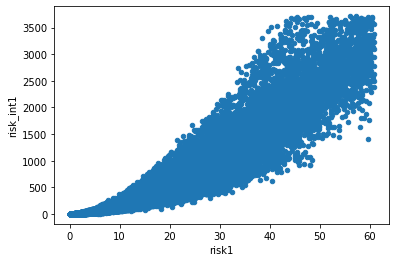

In [27]:
df2.plot.scatter('risk1','risk_int1')

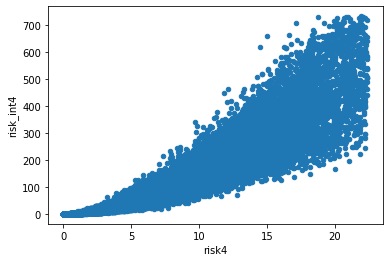

In [28]:
df2.plot.scatter('risk4','risk_int4')

In [29]:
df2 = df2.drop(['cluster_C_y','cluster_D_y','cluster_ctrl','risk_int1','risk_int4'], axis=1)
df2.iloc[:,2:].corr().style.apply(lambda x: ["background: red" if abs(v) > 0.75 else "" for v in x], axis = 1)

,distance1_2_x,distance3_4_x,cluster_B_x,cluster_C_x,cluster_D_x,distance1_2_y,distance3_4_y,cluster_B_y,agility_y,landing_risk1,landing_risk4,risk1,risk4,risk_category,distance_ctrl,distance_std_ctrl,cluster_std_ctrl,risk_ctrl,agi_ctrl,exp,ranking
distance1_2_x,1,0.141215,0.107219,0.0899015,0.083418,-0.11716,0.00113322,0.0366778,-0.240066,-0.0604007,-0.0594699,-0.0602032,-0.0667037,-0.0678289,0.0263042,0.255239,0.0926123,-0.0881066,-0.104497,0.0095732,-0.191595
distance3_4_x,0.141215,1,0.0287539,0.0909555,0.173686,0.118786,-0.168791,0.0320767,0.0199345,-0.0442505,-0.0261888,-0.071749,-0.0396402,-0.0493926,-0.0318786,0.228662,-0.122347,0.0543271,0.0953928,0.042477,-0.1438
cluster_B_x,0.107219,0.0287539,1,0.425861,0.218903,0.305393,0.239676,0.65925,0.0607861,-0.201124,-0.280949,-0.229771,-0.356461,-0.246234,0.105348,-0.0320323,0.32478,-0.215739,-0.0500134,-0.0678196,-0.0970697
cluster_C_x,0.0899015,0.0909555,0.425861,1,0.666797,0.444547,0.434992,0.67252,0.0310985,-0.323572,-0.371941,-0.332649,-0.449721,-0.388376,0.0992084,-0.0230657,0.478267,-0.353917,-0.0884286,-0.0921627,-0.00264003
cluster_D_x,0.083418,0.173686,0.218903,0.666797,1,0.317178,0.444011,0.445156,-0.0486381,-0.281044,-0.283536,-0.278368,-0.346896,-0.337924,0.0690364,-0.00096008,0.423762,-0.320212,-0.103343,-0.0710322,-0.0140409
distance1_2_y,-0.11716,0.118786,0.305393,0.444547,0.317178,1,0.429962,0.59976,-0.0367294,-0.0864112,-0.165014,-0.105541,-0.237858,-0.12418,0.153254,0.020349,-0.0257943,0.04919,-0.0258355,-0.0270136,-0.225851
distance3_4_y,0.00113322,-0.168791,0.239676,0.434992,0.444011,0.429962,1,0.341086,0.0559898,-0.123299,-0.15698,-0.129095,-0.236383,-0.162239,0.0648624,-0.0419531,-0.00685422,-0.000922301,0.0396959,-0.00567547,-0.155178
cluster_B_y,0.0366778,0.0320767,0.65925,0.67252,0.445156,0.59976,0.341086,1,0.0747226,-0.235815,-0.318446,-0.231195,-0.389005,-0.290335,0.110059,-0.044441,0.355385,-0.228967,-0.0846681,-0.0654711,0.0485386
agility_y,-0.240066,0.0199345,0.0607861,0.0310985,-0.0486381,-0.0367294,0.0559898,0.0747226,1,-0.0299193,0.0147673,-0.0856946,-0.0210737,-0.0438505,-0.0751862,0.00329731,-0.0789515,-0.0120284,0.348161,0.00852731,0.378688
landing_risk1,-0.0604007,-0.0442505,-0.201124,-0.323572,-0.281044,-0.0864112,-0.123299,-0.235815,-0.0299193,1,0.450202,0.659904,0.534228,0.669488,-0.0335532,-0.0431009,-0.341798,0.42209,-0.00442812,0.0863146,-0.0156529


# EDA

In [48]:
pd.set_option('display.max_columns', 45)

In [49]:
df.columns

Index(['matchId', 'teamId', 'distance1_2_x', 'distance3_4_x',
       'distance_centroid1_x', 'distance_centroid4_x', 'cluster_B_x',
       'cluster_C_x', 'cluster_D_x', 'distance1_2_y', 'distance3_4_y',
       'distance_centroid1_y', 'distance_centroid4_y', 'cluster_B_y',
       'cluster_C_y', 'cluster_D_y', 'agility_y', 'landing_risk1',
       'landing_risk4', 'risk1', 'risk4', 'risk_category', 'risk_int1',
       'risk_int4', 'distance_ctrl', 'cluster_ctrl', 'distance_std_ctrl',
       'cluster_std_ctrl', 'risk_ctrl', 'agi_ctrl', 'exp', 'ranking'],
      dtype='object')

The _x_ variables represent standard deviations, while the _y_ variables represent means

In [50]:
df.nunique(axis=0)
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,teamId,distance1_2_x,distance3_4_x,distance_centroid1_x,distance_centroid4_x,cluster_B_x,cluster_C_x,cluster_D_x,distance1_2_y,distance3_4_y,distance_centroid1_y,distance_centroid4_y,cluster_B_y,cluster_C_y,cluster_D_y,agility_y,landing_risk1,landing_risk4,risk1,risk4,risk_category,risk_int1,risk_int4,distance_ctrl,cluster_ctrl,distance_std_ctrl,cluster_std_ctrl,risk_ctrl,agi_ctrl,exp,ranking
count,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000,114873.000000
mean,12.633517,0.247827,0.265930,0.416707,0.298594,0.133893,0.066955,0.024312,1.162352,0.621154,1.057956,0.884823,0.115004,0.033534,0.006920,0.236559,27.710280,3.041354,10.237749,3.411021,-0.233841,266.636420,39.458144,0.976229,0.054242,0.237104,0.075320,7.609353,0.236032,1.488963,12.034725
std,7.666426,0.091541,0.068278,0.235802,0.147838,0.044632,0.043943,0.031036,0.196720,0.131670,0.287485,0.231020,0.073494,0.035973,0.012162,0.109727,29.113202,5.348062,11.255785,4.210249,0.763614,503.936507,81.972999,0.024153,0.018133,0.022406,0.017377,5.011838,0.042199,2.034438,7.580084
min,1.000000,0.027609,0.018898,0.054803,0.001754,0.000000,0.000000,0.000000,0.516618,0.141848,-0.493141,-0.865191,0.000000,0.000000,0.000000,0.011299,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.897604,0.007276,0.164295,0.022667,0.000000,0.105676,0.000000,1.000000
25%,6.000000,0.181805,0.221940,0.293752,0.222399,0.112556,0.033405,0.000000,1.030420,0.531850,0.898321,0.725798,0.055227,0.004386,0.000000,0.153005,6.000000,0.000000,1.926829,0.538462,-1.000000,6.763061,0.615773,0.960129,0.039984,0.221909,0.061963,3.613132,0.207990,0.000000,6.000000
50%,12.000000,0.236533,0.263829,0.378722,0.281251,0.136761,0.070582,0.000000,1.152144,0.618526,1.081866,0.858501,0.108696,0.020833,0.000000,0.224880,18.000000,1.000000,5.952000,1.527473,0.000000,52.798529,4.164669,0.976592,0.054239,0.234838,0.077706,6.206777,0.236839,0.000000,11.000000
75%,18.000000,0.301972,0.306750,0.497973,0.347262,0.161081,0.104848,0.046005,1.277671,0.706286,1.248227,1.017070,0.165692,0.053030,0.008621,0.304762,39.062500,3.125000,14.944307,4.853723,0.000000,282.909974,37.061132,0.992565,0.067785,0.248858,0.089271,11.185405,0.265043,3.574633,18.000000
max,35.000000,0.629297,0.515999,8.414860,5.626839,0.255377,0.167577,0.113067,1.833634,1.094686,2.651593,2.353429,0.351592,0.163146,0.062500,0.587302,150.000000,30.000000,60.790698,22.390805,1.000000,3715.016273,734.343312,1.052881,0.109152,0.337355,0.115870,23.675138,0.363349,7.723608,33.000000


distance1_2_x


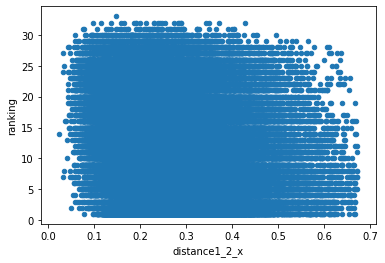

distance3_4_x


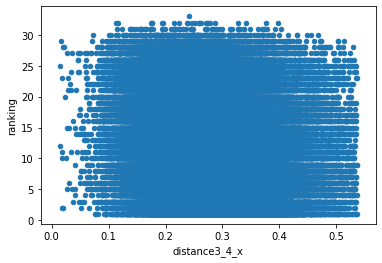

distance_centroid1_x


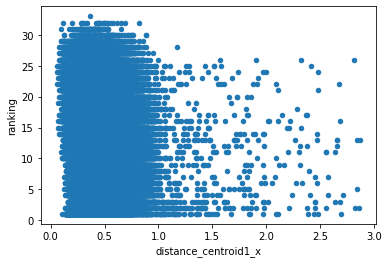

distance_centroid4_x


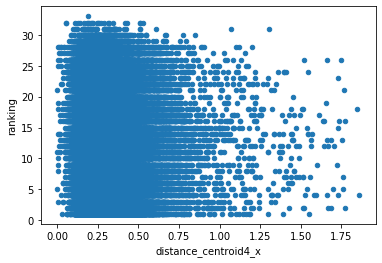

cluster_B_x


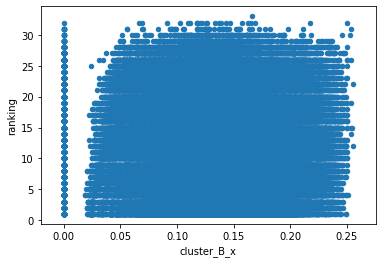

cluster_C_x


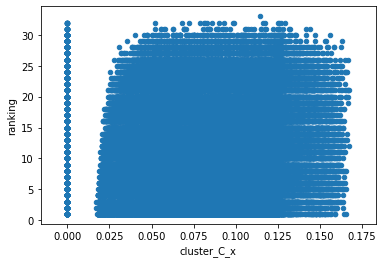

cluster_D_x


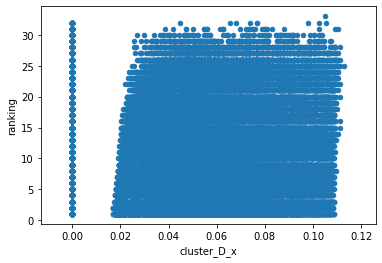

distance1_2_y


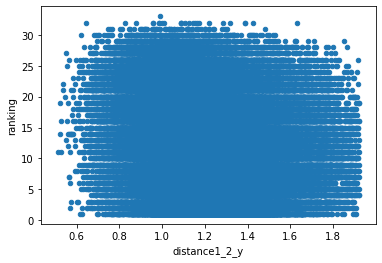

distance3_4_y


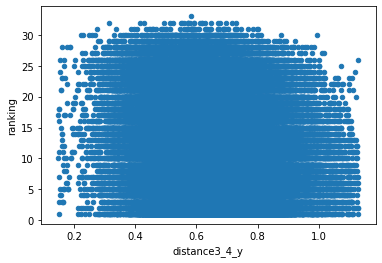

distance_centroid1_y


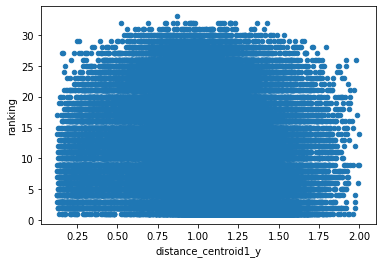

distance_centroid4_y


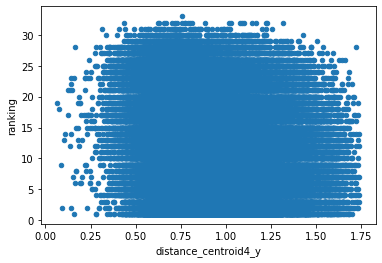

cluster_B_y


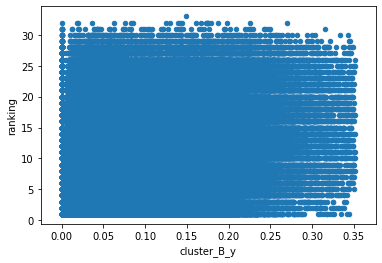

cluster_C_y


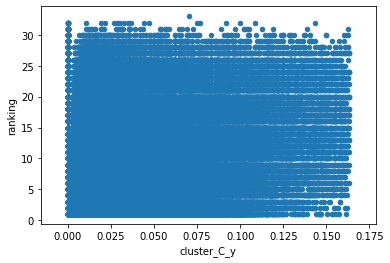

cluster_D_y


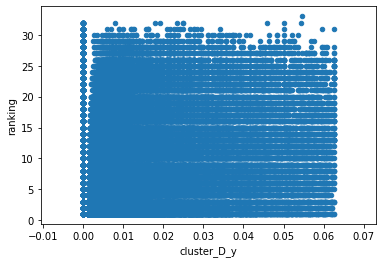

agility_y


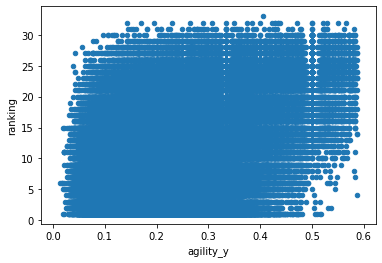

landing_risk1


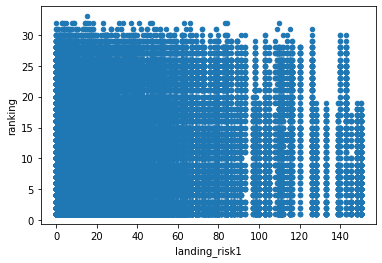

landing_risk4


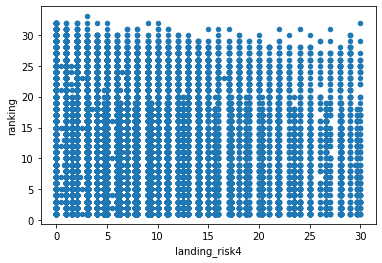

risk1


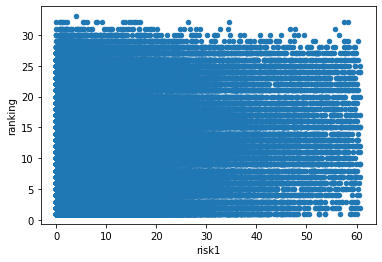

risk4


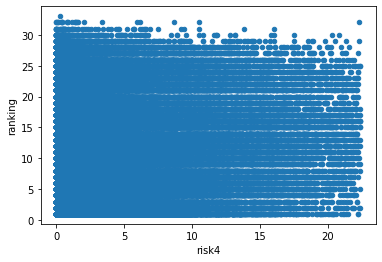

risk_category


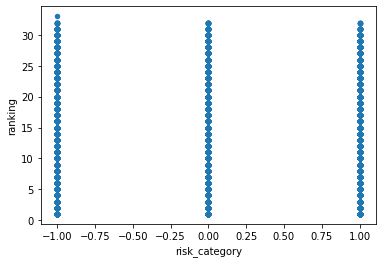

risk_int1


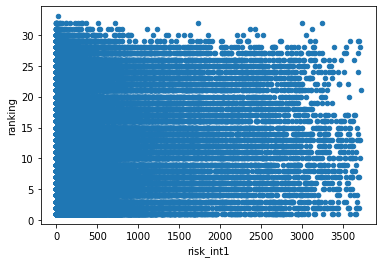

risk_int4


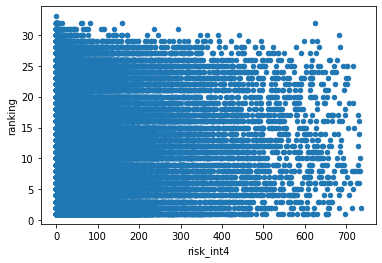

distance_ctrl


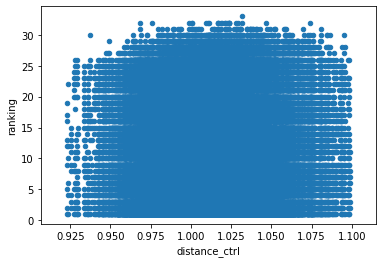

cluster_ctrl


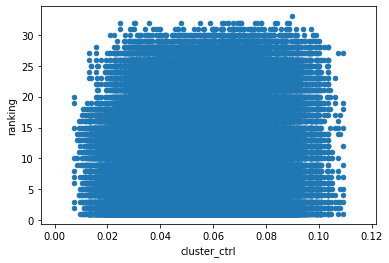

distance_std_ctrl


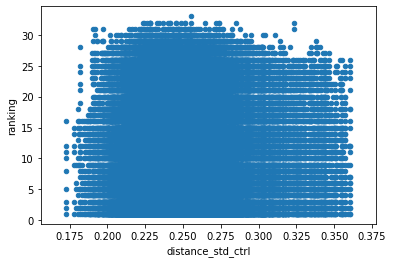

cluster_std_ctrl


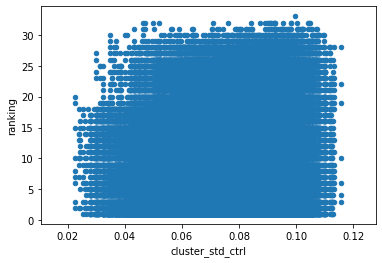

risk_ctrl


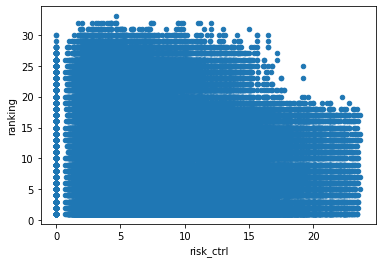

agi_ctrl


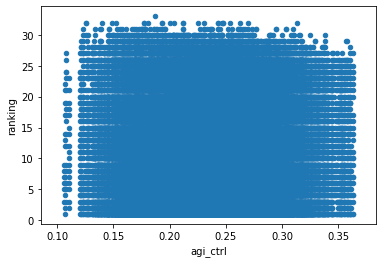

exp


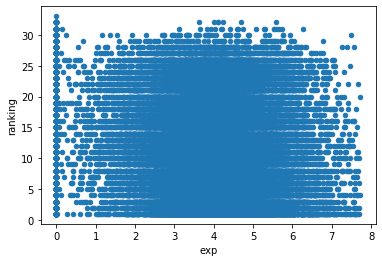

ranking


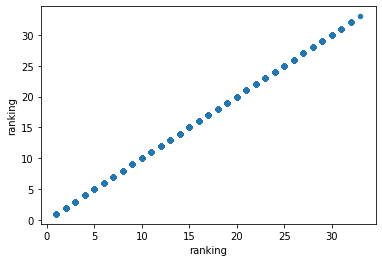

In [130]:
for i in df.iloc[:,2:].columns:
    print(f'{i}')
    df.plot.scatter(i,'ranking')
    plt.show()

distance1_2_x


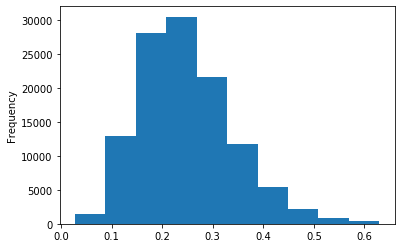

distance3_4_x


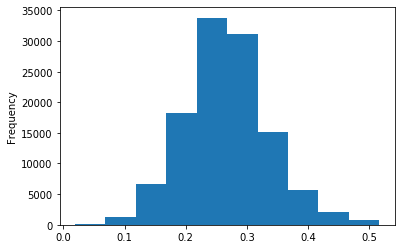

distance_centroid1_x


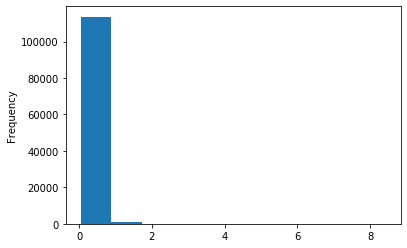

distance_centroid4_x


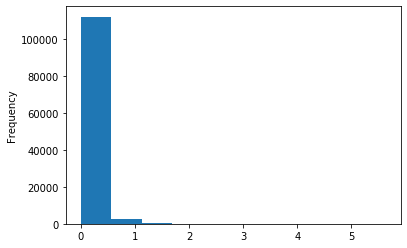

cluster_B_x


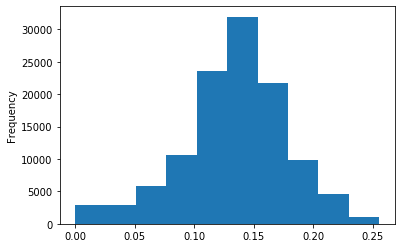

cluster_C_x


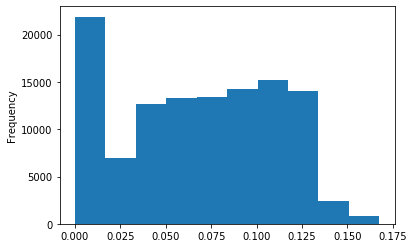

cluster_D_x


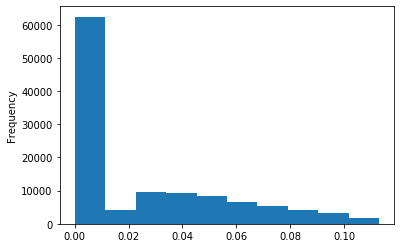

distance1_2_y


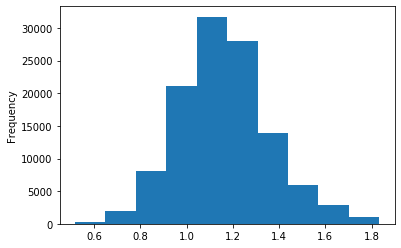

distance3_4_y


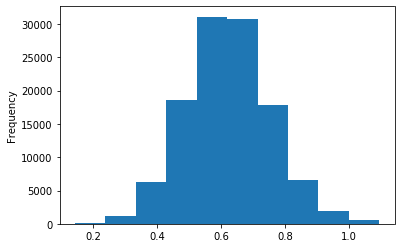

distance_centroid1_y


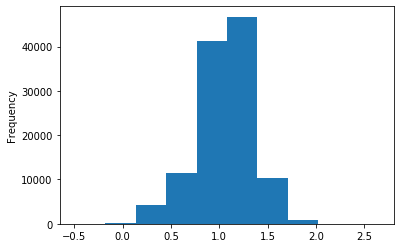

distance_centroid4_y


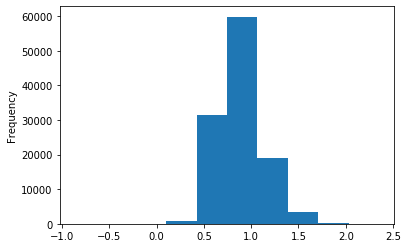

cluster_B_y


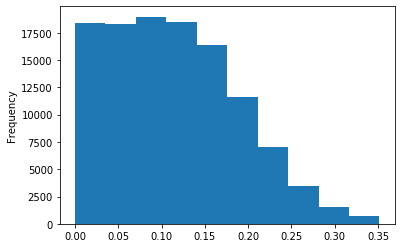

cluster_C_y


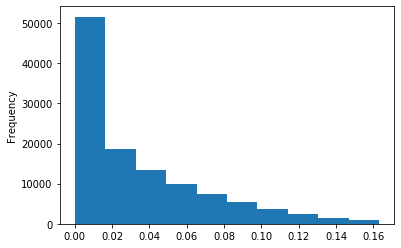

cluster_D_y


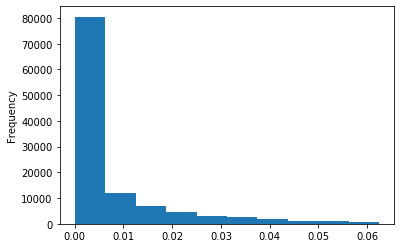

agility_y


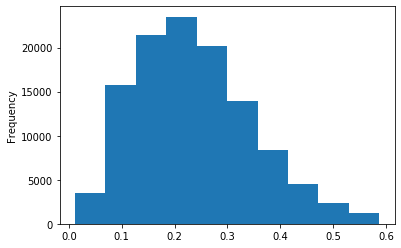

landing_risk1


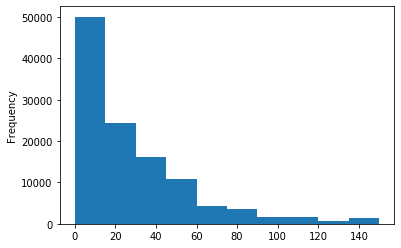

landing_risk4


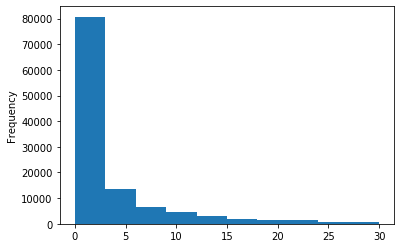

risk1


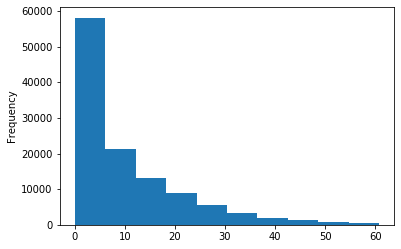

risk4


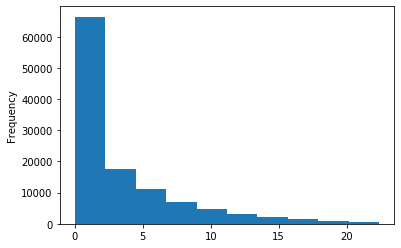

risk_category


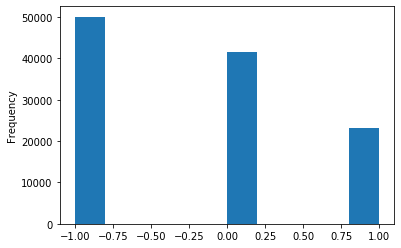

risk_int1


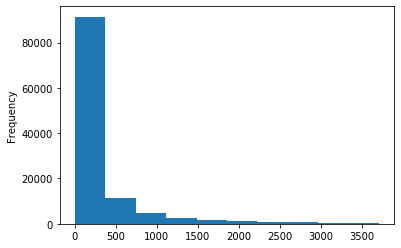

risk_int4


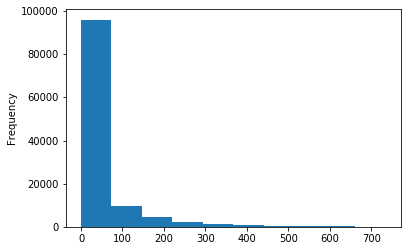

distance_ctrl


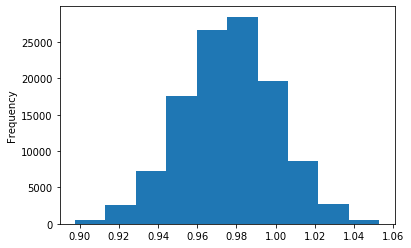

cluster_ctrl


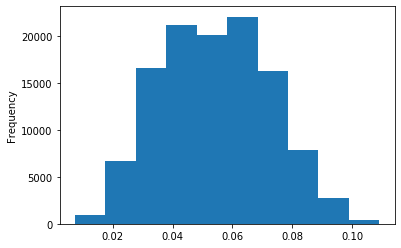

distance_std_ctrl


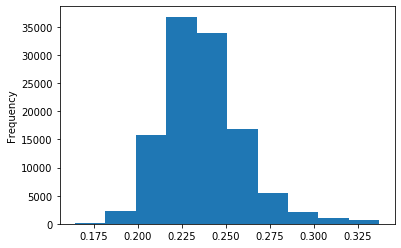

cluster_std_ctrl


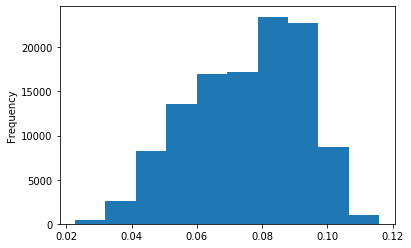

risk_ctrl


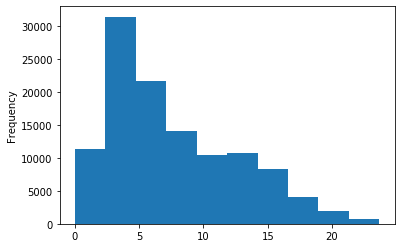

agi_ctrl


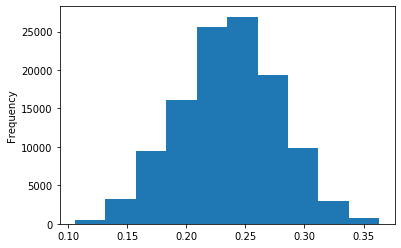

exp


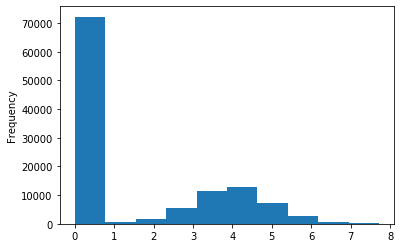

ranking


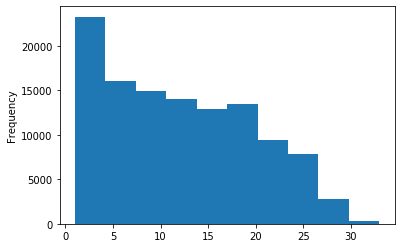

In [52]:
for i in df.iloc[:,2:].columns:
    print(f'{i}')
    df[i].plot.hist()
    plt.show()

# Models

In [30]:
import numpy as np
import pandas as pd
import os
import math
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, SGDClassifier
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier, XGBRegressor

## All variables

From now on, I use the df with distances and cluster, not centroids

In [31]:
X = df2.iloc[:,2:-1]
y = df2.iloc[:,[-1]]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=6, shuffle=True)

### Regression

In [34]:
# Linear Regression
X_t=sm.add_constant(X_train)
model = sm.OLS(y_train,X_t.astype(float), hasconst=True)
model = model.fit(cov_type = 'HC1')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ranking   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     3512.
Date:                Mon, 29 Jun 2020   Prob (F-statistic):               0.00
Time:                        12:09:01   Log-Likelihood:            -2.9333e+05
No. Observations:               91700   AIC:                         5.867e+05
Df Residuals:                   91679   BIC:                         5.869e+05
Df Model:                          20                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                18.6170      0.881     21.121      0.000      16.889      20.345
distance1_2_x       -12.0827      0.236    -51.118      0.000     -12.546     -11.619
distance3_4_x       -12.9801      0.348    -37.285      0.000     -13.662     -12.298
cluster_B_x         -41.7640      0.605    -69.017      0.000     -42.950     -40.578
cluster_C_x          -1.5300      0.778     -1.967      0.049      -3.054      -0.005
cluster_D_x          15.2369      0.993     15.343      0.000      13.291      17.183
distance1_2_y       -12.1914      0.160    -76.137      0.000     -12.505     -11.878
distance3_4_y        -8.1393      0.206    -39.465      0.000      -8.544      -7.735
cluster_B_y          41.1436      0.517     79.605      0.000      40.131      42.157
agility_y            25.4010      0.200    127.060      0.000      25.009      25.793
landing_risk1        -0.0141      0.001    -15.068      0.000      -0.016      -0.012
landing_risk4        -0.0347      0.004     -8.120      0.000      -0.043      -0.026
risk1                 0.2293      0.003     73.966      0.000       0.223       0.235
risk4                -0.0794      0.007    -10.915      0.000      -0.094      -0.065
risk_category        -0.9354      0.049    -19.106      0.000      -1.031      -0.839
distance_ctrl        14.6750      0.832     17.645      0.000      13.045      16.305
distance_std_ctrl    25.5639      0.893     28.633      0.000      23.814      27.314
cluster_std_ctrl    -37.9796      2.188    -17.356      0.000     -42.268     -33.691
risk_ctrl            -0.3616      0.007    -55.169      0.000      -0.374      -0.349
agi_ctrl            -10.8120      0.547    -19.779      0.000     -11.883      -9.741
exp                  -0.1361      0.010    -14.162      0.000      -0.155      -0.117
==============================================================================
Omnibus:                     1045.337   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              884.582
Skew:                           0.180   Prob(JB):                    8.23e-193
Kurtosis:                       2.680   Cond. No.                     4.96e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [216]:
X_t3 = X_t.drop(['distance1_2_x','distance3_4_x', 'distance1_2_y','distance3_4_y', 'distance_ctrl'], axis=1)
# Linear Regression
model3 = sm.OLS(y_train,X_t3.astype(float), hasconst=True).fit(cov_type = 'HC1')

model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ranking   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     3572.
Date:                Mon, 29 Jun 2020   Prob (F-statistic):               0.00
Time:                        10:26:50   Log-Likelihood:            -2.9918e+05
No. Observations:               91635   AIC:                         5.984e+05
Df Residuals:                   91619   BIC:                         5.985e+05
Df Model:                          15                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.4145      0.365     28.569      0.000       9.700      11.129
cluster_B_x         -44.7219      0.615    -72.721      0.000     -45.927     -43.517
cluster_C_x         -20.4222      0.784    -26.033      0.000     -21.960     -18.885
cluster_D_x         -12.5385      0.953    -13.153      0.000     -14.407     -10.670
cluster_B_y          22.4589      0.450     49.912      0.000      21.577      23.341
agility_y            30.5032      0.189    161.234      0.000      30.132      30.874
landing_risk1        -0.0172      0.001    -17.238      0.000      -0.019      -0.015
landing_risk4        -0.0313      0.004     -6.982      0.000      -0.040      -0.023
risk1                 0.2383      0.003     73.609      0.000       0.232       0.245
risk4                 0.0440      0.008      5.807      0.000       0.029       0.059
risk_category        -1.1218      0.052    -21.524      0.000      -1.224      -1.020
distance_std_ctrl     2.4428      0.858      2.849      0.004       0.762       4.123
cluster_std_ctrl     47.8225      2.062     23.194      0.000      43.781      51.864
risk_ctrl            -0.4002      0.007    -57.956      0.000      -0.414      -0.387
agi_ctrl            -16.1416      0.574    -28.121      0.000     -17.267     -15.017
exp                  -0.1042      0.010     -9.994      0.000      -0.125      -0.084
==============================================================================
Omnibus:                     2432.608   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1243.200
Skew:                           0.064   Prob(JB):                    1.10e-270
Kurtosis:                       2.444   Cond. No.                     4.47e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [206]:
X_t1 = X_t.drop(['landing_risk1','landing_risk4', 'risk1','risk4', 'risk_ctrl'], axis=1)
# Linear Regression
model1 = sm.OLS(y_train,X_t1.astype(float), hasconst=True).fit(cov_type = 'HC1')

model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ranking   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     3513.
Date:                Mon, 29 Jun 2020   Prob (F-statistic):               0.00
Time:                        10:15:41   Log-Likelihood:            -2.9673e+05
No. Observations:               91635   AIC:                         5.935e+05
Df Residuals:                   91619   BIC:                         5.937e+05
Df Model:                          15                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.9114      0.897     14.399      0.000      11.154      14.669
distance1_2_x       -12.0990      0.246    -49.130      0.000     -12.582     -11.616
distance3_4_x       -13.8451      0.359    -38.540      0.000     -14.549     -13.141
cluster_B_x         -45.7003      0.616    -74.143      0.000     -46.908     -44.492
cluster_C_x          -3.6602      0.809     -4.526      0.000      -5.245      -2.075
cluster_D_x          14.8896      1.026     14.517      0.000      12.879      16.900
distance1_2_y       -12.6678      0.166    -76.259      0.000     -12.993     -12.342
distance3_4_y        -7.6970      0.210    -36.657      0.000      -8.109      -7.285
cluster_B_y          43.7447      0.532     82.155      0.000      42.701      44.788
agility_y            24.2116      0.210    115.434      0.000      23.801      24.623
risk_category         0.4109      0.031     13.078      0.000       0.349       0.473
distance_ctrl        12.3605      0.863     14.319      0.000      10.669      14.052
distance_std_ctrl    31.2273      0.912     34.234      0.000      29.439      33.015
cluster_std_ctrl     37.8653      1.766     21.444      0.000      34.404      41.326
agi_ctrl             -5.3018      0.541     -9.791      0.000      -6.363      -4.241
exp                  -0.1572      0.010    -15.421      0.000      -0.177      -0.137
==============================================================================
Omnibus:                     1800.602   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1345.555
Skew:                           0.204   Prob(JB):                    6.55e-293
Kurtosis:                       2.570   Cond. No.                         266.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [207]:
X_t2 = X_t1.drop(['cluster_B_x','cluster_C_x', 'cluster_D_x', 'cluster_B_y'], axis=1)
# Linear Regression
model2 = sm.OLS(y_train,X_t2.astype(float), hasconst=True).fit(cov_type = 'HC1')

model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ranking   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3847.
Date:                Mon, 29 Jun 2020   Prob (F-statistic):               0.00
Time:                        10:15:53   Log-Likelihood:            -3.0134e+05
No. Observations:               91635   AIC:                         6.027e+05
Df Residuals:                   91623   BIC:                         6.028e+05
Df Model:                          11                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.2178      0.940     11.930      0.000       9.375      13.061
distance1_2_x       -11.2216      0.249    -45.151      0.000     -11.709     -10.734
distance3_4_x       -12.7873      0.334    -38.248      0.000     -13.443     -12.132
distance1_2_y        -6.0092      0.124    -48.444      0.000      -6.252      -5.766
distance3_4_y        -6.4612      0.185    -35.019      0.000      -6.823      -6.100
agility_y            26.4371      0.202    130.670      0.000      26.041      26.834
risk_category         0.3310      0.033     10.104      0.000       0.267       0.395
distance_ctrl         2.7222      0.886      3.071      0.002       0.985       4.459
distance_std_ctrl    26.1284      0.937     27.877      0.000      24.291      27.965
cluster_std_ctrl     75.6524      1.422     53.209      0.000      72.866      78.439
agi_ctrl             -9.6141      0.567    -16.962      0.000     -10.725      -8.503
exp                  -0.1366      0.011    -12.770      0.000      -0.158      -0.116
==============================================================================
Omnibus:                     3468.445   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1572.571
Skew:                           0.069   Prob(JB):                         0.00
Kurtosis:                       2.373   Cond. No.                         207.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [208]:
y_pred = model.predict(X_t)

In [209]:
diff = y_train.copy()
diff['pred'] = y_pred

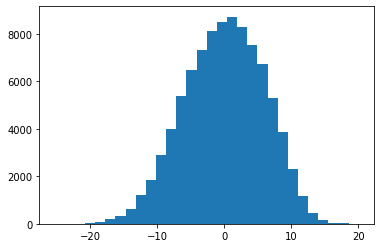

In [210]:
plt.hist([diff['pred']-diff['ranking']], bins=30)
plt.show()

Check the distribution of the errors 

In [211]:
metrics.r2_score(y_train, y_pred)

0.3896483126585665

In [212]:
mean_squared_error(y_train, y_pred)

35.120455527685216

In [213]:
X_ts = sm.add_constant(X_test)
y_pred = model.predict(X_ts)

C:\Users\admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [214]:
metrics.r2_score(y_test, y_pred)

0.3897204907214529

In [215]:
mean_squared_error(y_test, y_pred)

34.980223224728164

In [161]:
# Linear regression (scikit learn)
kfold=KFold(n_splits=10, random_state=7)

model=LinearRegression()
scoring = "neg_mean_squared_error"

results=cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print(f'Linear Regression - MSE {results.mean():.3f} std {results.std():.3f}')

# Create the DataFrames for plotting
resall=pd.DataFrame()
res_w1=pd.DataFrame()

res_w1["Res"]=results
res_w1["Type"]="Lin"

resall=pd.concat([resall,res_w1], ignore_index=True)

# Now lets use it in the same way than the statsmodel

model_x=LinearRegression()
model_x.fit(X_train,y_train)
print(f'Intercept {model_x.intercept_}')
print("Coefficients ",model_x.coef_)

y_pred_x=model_x.predict(X_train)

print(f'MAE - Mean Absolute Error {mean_absolute_error(y_train, y_pred_x):.3f}')
print(f'MSE - Mean Square Error  {mean_squared_error(y_train, y_pred_x):.3f}')
print(f'R2    {metrics.r2_score(y_train, y_pred_x):.3f}')

Linear Regression - MSE -32.405 std 0.415
Intercept [25.44654988]
Coefficients  [[-1.36479797e+01 -1.27851741e+01 -3.61377846e+01 -2.88095125e+01
  -1.37152367e+01 -8.39657453e+00  3.94862612e+01  3.75895689e+01
   2.49354684e+01 -7.62571642e-03 -4.11552226e-02  5.29233869e-01
  -2.22398815e-02  1.56356369e+00 -6.14824298e-03 -6.20668284e-03
   3.79098826e+00 -1.36815954e+02  2.04581946e+01  1.05047283e+02
  -3.87103409e-01 -1.62061701e+01 -1.05570173e-01]]
MAE - Mean Absolute Error 4.610
MSE - Mean Square Error  32.389
R2    0.436


In [162]:
y_pred = model_x.predict(X_test)

In [163]:
# Ridge Regression
kfold=KFold(n_splits=10, random_state=7)

model=Ridge()
scoring = "neg_mean_squared_error"

results=cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

print(f'Ridge Regression - MSE {results.mean():.3f} std {results.std():.3f}')

res_w1["Res"]=results
res_w1["Type"]="Ridge"

resall=pd.concat([resall,res_w1], ignore_index=True)

Ridge Regression - MSE -32.494 std 0.411


In [164]:
model=Ridge()
model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [165]:
y_pred = model.predict(X_train)

In [166]:
metrics.r2_score(y_train, y_pred)

0.4348826026250504

In [167]:
mean_squared_error(y_train, y_pred)

32.46807113017018

In [168]:
y_pred = model.predict(X_test)

In [169]:
metrics.r2_score(y_test, y_pred)

0.44751097362713255

In [170]:
mean_squared_error(y_test, y_pred)

31.63708945814577

In [171]:
# KNN Regression
kfold=KFold(n_splits=10, random_state=7)

model=KNeighborsRegressor()
scoring = "neg_mean_squared_error"

results=cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

print(f'KNN Regression - MSE {results.mean():.3f} std {results.std():.3f}')

res_w1["Res"]=results
res_w1["Type"]="KNN"

resall=pd.concat([resall,res_w1], ignore_index=True)

KeyboardInterrupt: 

In [ ]:
model=KNeighborsRegressor()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_train)

In [ ]:
metrics.r2_score(y_train, y_pred)

In [ ]:
mean_squared_error(y_train, y_pred)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
metrics.r2_score(y_test, y_pred)

In [ ]:
mean_squared_error(y_test, y_pred)

### Classification

In [35]:
dfc = df2.copy()
dfc['ranking'] = dfc['ranking'].apply(lambda x: 1 if x <=5 else 0)

In [36]:
X = dfc.iloc[:,2:-1]
y = dfc.iloc[:,-1]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=6, shuffle = True)

In [70]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

LOGISTIC REGRESSION

In [50]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
y_pred = model.predict(X_train)
print('TRAIN METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_train, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_train, y_pred)}')
metrics.confusion_matrix(y_train,y_pred)

TRAIN METRICS
Accuracy: 0.6934336286617165
F1 Score: 0.5487028739404664


array([[52310, 25063],
       [ 6563, 19226]], dtype=int64)

In [52]:
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.68      0.77     77373
           1       0.43      0.75      0.55     25789

    accuracy                           0.69    103162
   macro avg       0.66      0.71      0.66    103162
weighted avg       0.77      0.69      0.71    103162



In [53]:
y_pred = model.predict(X_test)
print('TEST METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_test, y_pred)}')
metrics.confusion_matrix(y_test,y_pred)

TEST METRICS
Accuracy: 0.6919654540696153
F1 Score: 0.5504774029280712


array([[5770, 2847],
       [ 684, 2162]], dtype=int64)

In [54]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.67      0.77      8617
           1       0.43      0.76      0.55      2846

    accuracy                           0.69     11463
   macro avg       0.66      0.71      0.66     11463
weighted avg       0.78      0.69      0.71     11463



STOCHASTIC GRADIENT DESCENT

In [46]:
model = SGDClassifier(class_weight='balanced')
model.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [47]:
y_pred = model.predict(X_train)
print('TRAIN METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_train, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_train, y_pred)}')
metrics.confusion_matrix(y_train,y_pred)

TRAIN METRICS
Accuracy: 0.5769275508423645
F1 Score: 0.5004521054378556


array([[37655, 39718],
       [ 3927, 21862]], dtype=int64)

In [48]:
y_pred = model.predict(X_test)
print('TEST METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_test, y_pred)}')
metrics.confusion_matrix(y_test,y_pred)

TEST METRICS
Accuracy: 0.5700950885457559
F1 Score: 0.4957020057306591


array([[4113, 4504],
       [ 424, 2422]], dtype=int64)

In [49]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.48      0.63      8617
           1       0.35      0.85      0.50      2846

    accuracy                           0.57     11463
   macro avg       0.63      0.66      0.56     11463
weighted avg       0.77      0.57      0.59     11463



XGBCLASSIFIER

In [38]:
len([i for i in y_train if i == 0]) / len([i for i in y_train if i == 1])

3.0002326573345224

In [39]:
model = XGBClassifier(scale_pos_weight=2, booster='gbtree', gamma=65, min_child_weight=50)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=65, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=50, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=2, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
y_pred = model.predict(X_train)
print('TRAIN METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_train, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_train, y_pred)}')
metrics.confusion_matrix(y_train,y_pred)

TRAIN METRICS
Accuracy: 0.787567127430643
F1 Score: 0.6314514908430452


array([[62473, 14900],
       [ 7015, 18774]], dtype=int64)

In [41]:
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85     77373
           1       0.56      0.73      0.63     25789

    accuracy                           0.79    103162
   macro avg       0.73      0.77      0.74    103162
weighted avg       0.81      0.79      0.80    103162



In [42]:
metrics.average_precision_score(y_train,y_pred)

0.4738674766068845

In [43]:
metrics.roc_auc_score(y_pred,y_train)

0.7282847207081276

In [44]:
y_pred = model.predict(X_test)
print('TEST METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_test, y_pred)}')
metrics.confusion_matrix(y_test,y_pred)

TEST METRICS
Accuracy: 0.777283433656111
F1 Score: 0.615685684178835


array([[6865, 1752],
       [ 801, 2045]], dtype=int64)

In [45]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.80      0.84      8617
           1       0.54      0.72      0.62      2846

    accuracy                           0.78     11463
   macro avg       0.72      0.76      0.73     11463
weighted avg       0.81      0.78      0.79     11463



In [201]:
metrics.average_precision_score(y_test,y_pred)

0.4581989822733413

In [202]:
metrics.roc_auc_score(y_pred,y_test)

0.7185110557054339

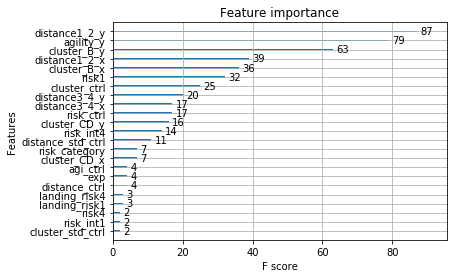

In [203]:
from xgboost import plot_importance
plot_importance(model.get_booster())